In [4]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt


def find_run_summaries(base_dir):
    run_summaries = []
    for d in Path(base_dir).iterdir():
        if d.is_dir():
            run_summary = list(d.rglob("**/run_summary.json"))
            if run_summary:
                run_summaries.extend(run_summary)
            else:
                print(f"No run_summary.json found in {d}")
    return run_summaries


def extract_metrics(summary_path, metrics_mode="standard", additional_config_keys=[]):
    with open(summary_path, "r") as f:
        d = json.load(f)
    res = {}
    subset_size = None
    # old: at root; new: sometimes nested under "config"
    config = d.get("config", d)
    subset_size = config.get("subset_size", None)
    if subset_size is not None:
        subset_size = float(subset_size)
    # Collect metrics per main.py convention
    res["subset_size"] = subset_size
    if metrics_mode == "test_model":
        tmr = d.get("test_model_result", {}) or {}
        res["acc"] = tmr.get("test_acc", None)
        res["fpr"] = tmr.get("test_fpr", None)
        res["fnr"] = tmr.get("test_fnr", None)
        res["f1"] = tmr.get("test_f1", None)
    else:
        res["acc"] = d.get("test_acc", None)
        res["fpr"] = d.get("test_fpr", None)
        res["fnr"] = d.get("test_fnr", None)
        res["f1"] = d.get("test_f1", None)
    res["category_distribution"] = None
    res["label_distribution"] = None
    for key in additional_config_keys:
        keys = key.split("->")
        temp = config
        for k in keys:
            v = temp.get(k, None)
            if v is None:
                break
            temp = v
        res[key] = temp
    dataset_summary = d.get("dataset_summary", None)
    if dataset_summary:
        cat_dist = dataset_summary.get("category_distribution", None)
        if cat_dist:
            res["category_distribution"] = cat_dist
        label_dist = dataset_summary.get("label_distribution", None)
        if label_dist:
            res["label_distribution"] = label_dist
    return res


def merge_nested_dicts(list_of_dicts):
    # Merge a list of dicts with same keys, summing values for each key
    merged = {}
    for d in list_of_dicts:
        for k, v in d.items():
            merged.setdefault(k, [])
            merged[k].append(v)
    # now, for each key, make sure all lists are the same length, pad with zeros if needed
    all_keys = list(merged)
    maxlen = max(len(v) for v in merged.values())
    for k in all_keys:
        n = len(merged[k])
        if n < maxlen:
            merged[k] += [0] * (maxlen - n)
    return merged


def plot_metrics(metrics, outpath, metrics_mode="standard", plot_title=None):
    """
    outpath: The full path to the image file (should end with .png etc)
    """
    subset_sizes = sorted(
        set(m["subset_size"] for m in metrics if m["subset_size"] is not None)
    )
    # Group metrics by subset size
    metrics_by_subset = {sz: [] for sz in subset_sizes}
    for m in metrics:
        if m["subset_size"] is not None:
            metrics_by_subset[m["subset_size"]].append(m)
    avgs = {k: [] for k in ["acc", "fpr", "fnr", "f1"]}
    stds = {k: [] for k in ["acc", "fpr", "fnr", "f1"]}
    for sz in subset_sizes:
        ms = metrics_by_subset[sz]
        for k in avgs:
            vals = [m[k] for m in ms if m[k] is not None]
            avgs[k].append(np.nanmean(vals) if vals else np.nan)
            stds[k].append(np.nanstd(vals, ddof=1) if vals else np.nan)
    fig = plt.figure(figsize=(8, 5), dpi=150)
    for k, label, marker in zip(
        ["acc", "fpr", "fnr", "f1"],
        ["Accuracy", "FPR", "FNR", "F1"],
        ["o", "s", "^", "d"],
    ):
        plt.errorbar(
            subset_sizes, avgs[k], yerr=stds[k], label=label, marker=marker, capsize=3
        )
    plt.xlabel("Subset size")
    plt.ylabel("Metric value")
    mode_label = "Standard" if metrics_mode == "standard" else "Test-Model"
    if plot_title is None:
        plt.title(f"Average evaluation metrics vs subset size ({mode_label})")
    else:
        plt.title(plot_title)
    plt.xlim(min(subset_sizes), max(subset_sizes))
    plt.xscale("log")
    plt.ylim(0.0, 1.0)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    outdir = os.path.dirname(outpath)
    os.makedirs(outdir, exist_ok=True)
    plt.savefig(outpath)
    print(f"Saved average metrics vs subset size plot to {outpath}")


def plot_metric_by_config(metrics, outpath, config_key="num_phi", title=None):
    """
    Plot F1 score vs subset size, one line per config_key value (e.g., num_phi).
    Error bars denote std over seeds for each (config_key, subset_size).
    Args:
        metrics: List of dicts representing each run's metrics and config
        outpath: Path to save the plot (including filename, e.g. foo/bar.png)
        config_key: The config key to group by (e.g., "num_phi")
    """
    # Group: (config_val) -> {subset_size: list of f1s over seeds}
    groups = dict()
    for m in metrics:
        # Get config value: must look inside config if available, fallback to top-level.
        config_val = None
        if config_key not in m:
            print(f"Config key {config_key} not in {m}")
            continue
        config_val = m[config_key]
        subset_size = m.get("subset_size", None)
        f1 = m.get("f1", None)
        if subset_size is None or f1 is None:
            continue
        if config_val not in groups:
            groups[config_val] = dict()
        if subset_size not in groups[config_val]:
            groups[config_val][subset_size] = []
        groups[config_val][subset_size].append(f1)

    # Sort config values numerically if possible
    try:
        config_vals = sorted(groups.keys(), key=lambda v: float(v))
    except Exception:
        config_vals = sorted(groups.keys(), key=lambda v: str(v))

    # Collect all subset sizes and sort
    all_subset_sizes = set()
    for group in groups.values():
        all_subset_sizes.update(group.keys())
    all_subset_sizes = sorted(all_subset_sizes)

    print(f"All subset sizes: {all_subset_sizes}")
    print(f"Config values: {config_vals}")

    # Prepare for plotting: For each config_val, collect mean/std f1 for each subset_size
    fig = plt.figure(figsize=(8, 5), dpi=150)
    colors = plt.cm.viridis(np.linspace(0, 1, len(config_vals)))
    for color, conf_val in zip(colors, config_vals):
        means, stds = [], []
        ss_ordered = []
        for sz in all_subset_sizes:
            vals = groups[conf_val].get(sz, [])
            if vals:
                means.append(np.nanmean(vals))
                stds.append(np.nanstd(vals, ddof=1) if len(vals) > 1 else 0.0)
            else:
                means.append(np.nan)
                stds.append(np.nan)
            ss_ordered.append(sz)
        plt.errorbar(
            ss_ordered,
            means,
            yerr=stds,
            label=f"{conf_val}",
            marker="o",
            capsize=3,
            color=color,
        )
    plt.xlabel("Subset size")
    plt.ylabel("F1 score")
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"F1 vs Subset Size (per {config_key})")
    plt.xlim(min(all_subset_sizes), max(all_subset_sizes))
    plt.xscale("log")
    plt.ylim(0.0, 1.0)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.legend(title=config_key)
    plt.tight_layout()
    outdir = os.path.dirname(outpath)
    os.makedirs(outdir, exist_ok=True)
    fig.savefig(outpath)
    print(f"Saved F1 vs subset size plot by {config_key} to {outpath}")


def plot_category_label_distribution(metrics, category_outpath, label_outpath):
    """
    Plot and save both the category and label distribution plots to their respective file paths.

    Args:
        metrics: List of metric dicts
        category_outpath: Output file path for category distribution plot (e.g. foo/bar1.png)
        label_outpath: Output file path for label distribution plot (e.g. foo/bar2.png)
    """
    # We want to show category and label counts for each subset size, averaged and error-barred,
    # Group per subset size, then over random seeds, average.
    subset_sizes = sorted(
        set(m["subset_size"] for m in metrics if m["subset_size"] is not None)
    )
    metrics_by_subset = {sz: [] for sz in subset_sizes}
    for m in metrics:
        if m["subset_size"] is not None:
            metrics_by_subset[m["subset_size"]].append(m)

    # Get all possible categories and labels
    all_categories = set()
    all_labels = set()
    for m in metrics:
        cat_dist = m.get("category_distribution", None)
        if cat_dist:
            all_categories.update(cat_dist.keys())
        label_dist = m.get("label_distribution", None)
        if label_dist:
            all_labels.update(label_dist.keys())
    all_categories = sorted(list(all_categories))
    all_labels = sorted(list(all_labels))

    # Category distribution
    cat_mean = {sz: [] for sz in subset_sizes}
    cat_std = {sz: [] for sz in subset_sizes}
    for sz in subset_sizes:
        per_seed_counts = []
        for m in metrics_by_subset[sz]:
            cat_dist = m.get("category_distribution", {})
            # Ensure all categories present
            counts = [cat_dist.get(cat, 0) for cat in all_categories]
            per_seed_counts.append(counts)
        arr = np.array(per_seed_counts, dtype=float)
        cat_mean[sz] = (
            arr.mean(axis=0) if len(arr) > 0 else np.zeros(len(all_categories))
        )
        cat_std[sz] = (
            arr.std(axis=0, ddof=1) if len(arr) > 1 else np.zeros(len(all_categories))
        )
    # Plot as grouped barplot with error bars, one panel per subset size (or one panel w/ grouping)
    fig, ax = plt.subplots(figsize=(max(10, len(all_categories) * 0.7), 6))
    bar_width = 0.8 / len(subset_sizes)
    indices = np.arange(len(all_categories))
    colors = plt.cm.viridis(np.linspace(0, 1, len(subset_sizes)))
    for i, sz in enumerate(subset_sizes):
        offset = (i - len(subset_sizes) / 2) * bar_width + bar_width / 2
        ax.bar(
            indices + offset,
            cat_mean[sz],
            bar_width,
            yerr=cat_std[sz],
            label=f"{sz:.1f}",
            capsize=3,
            color=colors[i],
        )
    ax.set_xticks(indices)
    ax.set_xticklabels(all_categories, rotation=45, ha="right")
    ax.set_ylabel("Avg count per subset (± std)")
    ax.set_title("Category distribution per subset size")
    ax.legend(title="Subset size")
    plt.tight_layout()
    category_outdir = os.path.dirname(category_outpath)
    os.makedirs(category_outdir, exist_ok=True)
    plt.savefig(category_outpath)
    plt.close()
    print(f"Saved category distribution plot to {category_outpath}")

    # Label distribution
    label_mean = {sz: [] for sz in subset_sizes}
    label_std = {sz: [] for sz in subset_sizes}
    for sz in subset_sizes:
        per_seed_counts = []
        for m in metrics_by_subset[sz]:
            label_dist = m.get("label_distribution", {})
            counts = [label_dist.get(label, 0) for label in all_labels]
            per_seed_counts.append(counts)
        arr = np.array(per_seed_counts, dtype=float)
        label_mean[sz] = arr.mean(axis=0) if len(arr) > 0 else np.zeros(len(all_labels))
        label_std[sz] = (
            arr.std(axis=0, ddof=1) if len(arr) > 1 else np.zeros(len(all_labels))
        )
    fig, ax = plt.subplots(figsize=(max(7, len(all_labels) * 1.5), 4))
    bar_width = 0.8 / len(subset_sizes)
    indices = np.arange(len(all_labels))
    for i, sz in enumerate(subset_sizes):
        offset = (i - len(subset_sizes) / 2) * bar_width + bar_width / 2
        ax.bar(
            indices + offset,
            label_mean[sz],
            bar_width,
            yerr=label_std[sz],
            label=f"{sz:.1f}",
            capsize=3,
            color=colors[i],
        )
    ax.set_xticks(indices)
    ax.set_xticklabels(all_labels, rotation=0, ha="center")
    ax.set_ylabel("Avg label count (± std)")
    ax.set_title("Label distribution per subset size")
    ax.legend(title="Subset size")
    plt.tight_layout()
    label_outdir = os.path.dirname(label_outpath)
    os.makedirs(label_outdir, exist_ok=True)
    plt.savefig(label_outpath)
    plt.close()
    print(f"Saved label distribution plot to {label_outpath}")


def plot_metric_varying_label_distribution(metrics, outpath, title=None):
    """
    Plot metrics vs. label distribution.
    """
    # Group metrics by label distribution
    groups = dict()
    for m in metrics:
        label_dist = m.get("label_distribution", None)
        n_positive = label_dist.get("1", 0) if label_dist is not None else 0
        if n_positive not in groups:
            groups[n_positive] = []
        groups[n_positive].append(m)

    # Plot metrics vs. label distribution
    fig, ax = plt.subplots(figsize=(8, 5))
    avg_metrics = {k: [] for k in ["acc", "fpr", "fnr"]}
    std_metrics = {k: [] for k in ["acc", "fpr", "fnr"]}
    for n_positive, metrics in sorted(groups.items(), key=lambda x: x[0]):
        print(f"n_positive: {n_positive}")
        print(f"Metrics: {metrics}")
        # Calculate average metrics for this label distribution
        avg_metric = {
            "acc": np.mean([m.get("acc", 0) for m in metrics]),
            "fpr": np.mean([m.get("fpr", 0) for m in metrics]),
            "fnr": np.mean([m.get("fnr", 0) for m in metrics]),
        }
        label_dist = metrics[0].get("label_distribution", None)
        # x-axis: # positive labels for this distribution
        n_positive = label_dist.get("1", 0) if label_dist is not None else 0
        std_metric = {
            "acc": np.std([m.get("acc", 0) for m in metrics]),
            "fpr": np.std([m.get("fpr", 0) for m in metrics]),
            "fnr": np.std([m.get("fnr", 0) for m in metrics]),
        }
        avg_metrics["acc"].append(avg_metric["acc"])
        std_metrics["acc"].append(std_metric["acc"])
        avg_metrics["fpr"].append(avg_metric["fpr"])
        std_metrics["fpr"].append(std_metric["fpr"])
        avg_metrics["fnr"].append(avg_metric["fnr"])
        std_metrics["fnr"].append(std_metric["fnr"])

    n_positives = sorted(list(groups.keys()))
    for k, label, marker in zip(
        ["acc", "fpr", "fnr"],
        ["Accuracy", "FPR", "FNR"],
        ["o", "s", "^"],
    ):
        plt.errorbar(
            n_positives,
            avg_metrics[k],
            yerr=std_metrics[k],
            label=label,
            marker=marker,
            capsize=3,
        )
    ax.set_xlabel("# positive labels")
    ax.set_ylabel("Metric value")
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title("Accuracy, FPR, FNR vs # Positive Labels")
    ax.legend()
    plt.ylim(0.0, 1.0)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    outdir = os.path.dirname(outpath)
    os.makedirs(outdir, exist_ok=True)
    fig.savefig(outpath)
    print(f"Saved metrics vs label distribution plot to {outpath}")


def plot_roc_curve_varying_label_distribution(metrics, outpath, title=None):
    """
    Plot ROC curve by varying label distribution.
    """
    recalls = []
    precisions = []
    for m in metrics:
        num_sample = sum(m.get("label_distribution").values())
        n_positive = m.get("label_distribution").get("1", 0)
        p = n_positive / num_sample
        n = 1.0 - p
        tpr = 1.0 - m.get("fnr")
        tnr = 1.0 - m.get("fpr")
        fpr = m.get("fpr")
        fnr = m.get("fnr")

        # Confusion components as proportions of total
        tp = tpr * p
        fp = fpr * n

        denom_prec = tp + fp
        if denom_prec == 0.0:
            # Edge case: no predicted positives (tp==0 and fp==0). Define precision = 0.0.
            precision = 0.0
        else:
            precision = tp / denom_prec
        
        recalls.append(tpr)
        precisions.append(precision)
    # sort by recall
    recalls, precisions = zip(*sorted(zip(recalls, precisions)))
    plt.plot(recalls, precisions, marker="o", markersize=2)
    # baseline: y = x in dotted line
    plt.plot(
        [0, 1], [0, 1], linestyle="--", color="black", alpha=0.5, label="Baseline"
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    outdir = os.path.dirname(outpath)
    os.makedirs(outdir, exist_ok=True)
    plt.savefig(outpath)
    if title is not None:
        plt.title(title)
    else:
        plt.title("ROC Curve by Label Distribution")


No run_summary.json found in /scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-23/polytope_hb-21-29-49/.submitit
Found 125 run summary files.
All subset sizes: [0.001, 0.003162, 0.01, 0.03162, 0.1]
Config values: [1, 2, 3, 4, 5]
Saved F1 vs subset size plot by num_feature_extractor_layers to robustness_plots/qwen3-4b_increasing_subset_size.png


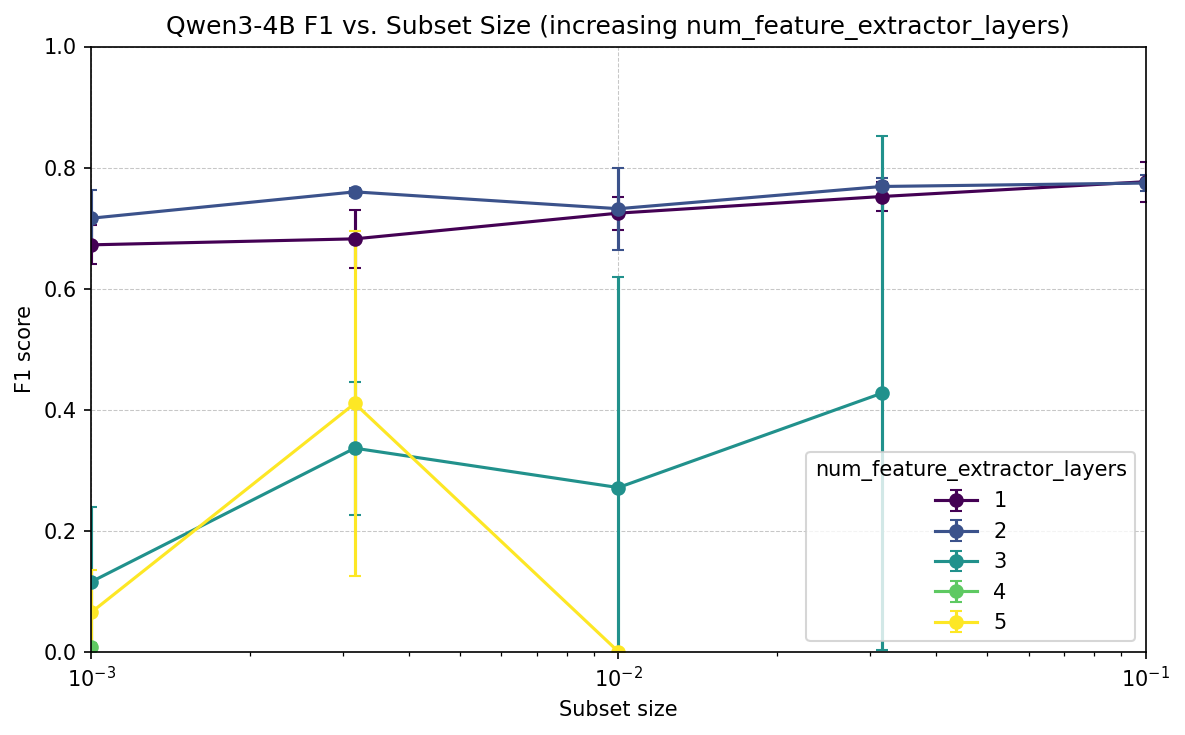

In [58]:
# qwen3-4b increasing num_feature_extractor_layers
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-23/polytope_hb-21-29-49",
]
metrics_mode = "standard"
outdir = "robustness_plots"
outpath = outdir + "/" + "qwen3-4b_increasing_subset_size.png"
run_summaries = []
additional_config_keys = ["num_feature_extractor_layers"]
for bd in base_dir:
    run_summaries.extend(find_run_summaries(bd))

title = "Qwen3-4B F1 vs. Subset Size (increasing num_feature_extractor_layers)"
print(f"Found {len(run_summaries)} run summary files.")
metrics = [
    extract_metrics(path, metrics_mode, additional_config_keys)
    for path in run_summaries
]
plot_metric_by_config(
    metrics, outpath, config_key="num_feature_extractor_layers", title=title
)

No run_summary.json found in /scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-23/polytope_hb-21-30-46/.submitit
Found 100 run summary files.
All subset sizes: [0.001, 0.003162, 0.01, 0.03162, 0.1]
Config values: [1, 25, 50, 75]
Saved F1 vs subset size plot by dataset->num_phi to robustness_plots/qwen3-4b_increasing_subset_size.png


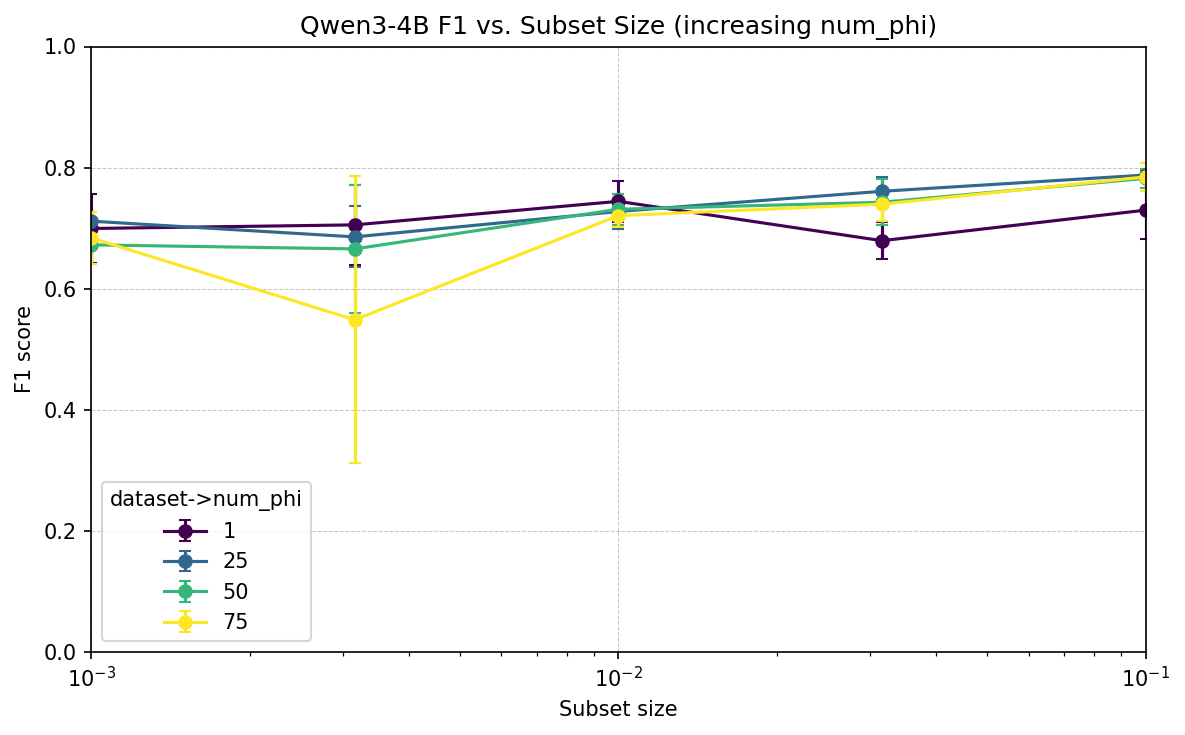

In [59]:
# qwen3-4b increasing num_phi
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-23/polytope_hb-21-30-46",
]
metrics_mode = "standard"
outdir = "robustness_plots"
outpath = outdir + "/" + "qwen3-4b_increasing_subset_size.png"
title = "Qwen3-4B F1 vs. Subset Size (increasing num_phi)"
run_summaries = []
additional_config_keys = ["dataset->num_phi"]
for bd in base_dir:
    run_summaries.extend(find_run_summaries(bd))

print(f"Found {len(run_summaries)} run summary files.")
metrics = [
    extract_metrics(path, metrics_mode, additional_config_keys)
    for path in run_summaries
]
plot_metric_by_config(metrics, outpath, config_key="dataset->num_phi", title=title)

Saved average metrics vs subset size plot to robustness_plots/ministral-8b_increasing_subset_size.png


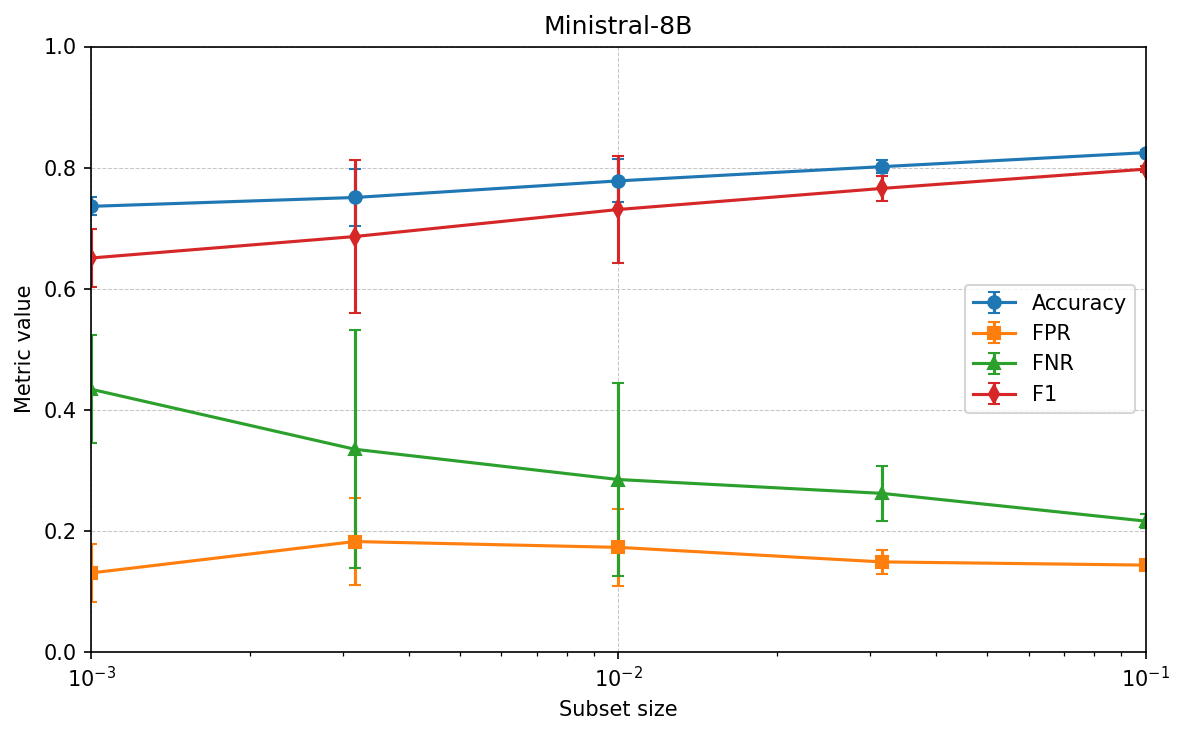

In [60]:
# ministral-8b increasing subset size
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-22/polytope_hb-18-25-05"
]

metrics_mode = "standard"
out_dir = "robustness_plots"
outpath = out_dir + "/" + "ministral-8b_increasing_subset_size.png"
run_summaries = find_run_summaries(base_dir[0])
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_metrics(metrics, outpath, metrics_mode, plot_title="Ministral-8B")

/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/7/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/21/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/24/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/6/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/3/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/11/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/19/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36/14/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_mod

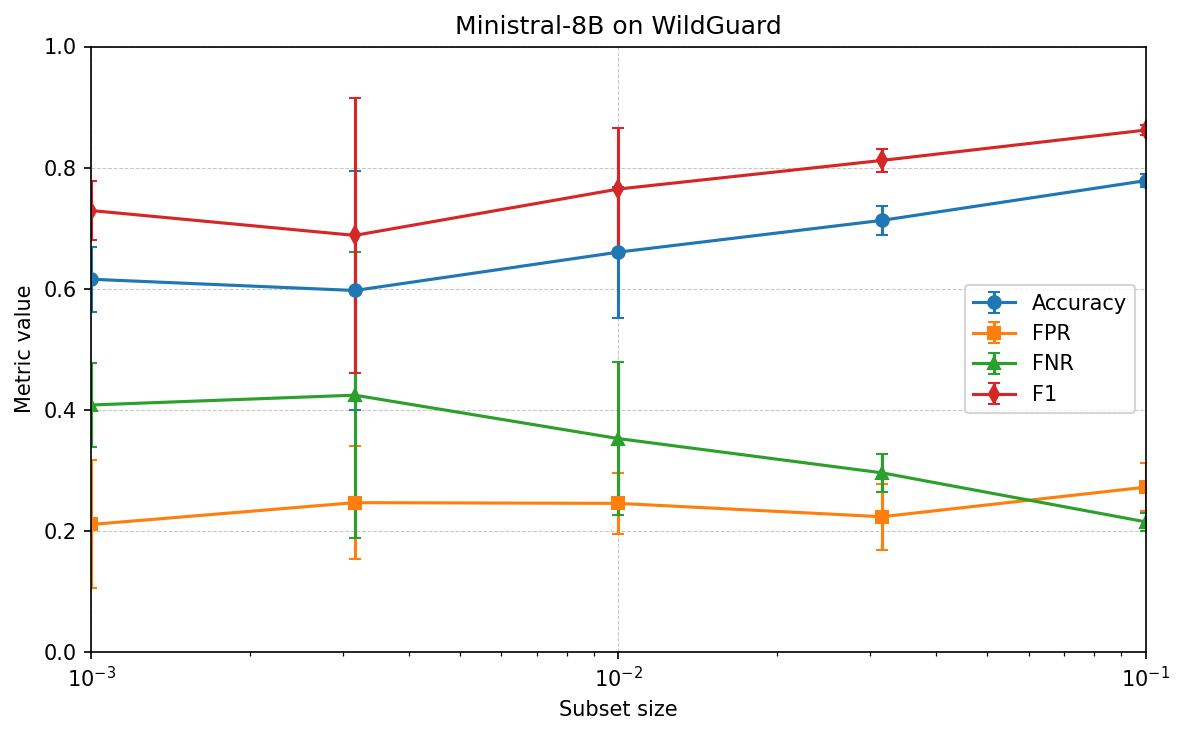

In [75]:
# ministral-8b increasing subset size on wildguard
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-12-36"
]

metrics_mode = "test_model"
out_dir = "robustness_plots"
outpath = out_dir + "/" + "ministral-8b_increasing_subset_size.png"
run_summaries = find_run_summaries(base_dir[0])
for r in run_summaries:
    print(r, end=",")
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_metrics(metrics, outpath, metrics_mode, plot_title="Ministral-8B on WildGuard")

Saved average metrics vs subset size plot to robustness_plots/qwen3-4b_increasing_subset_size.png


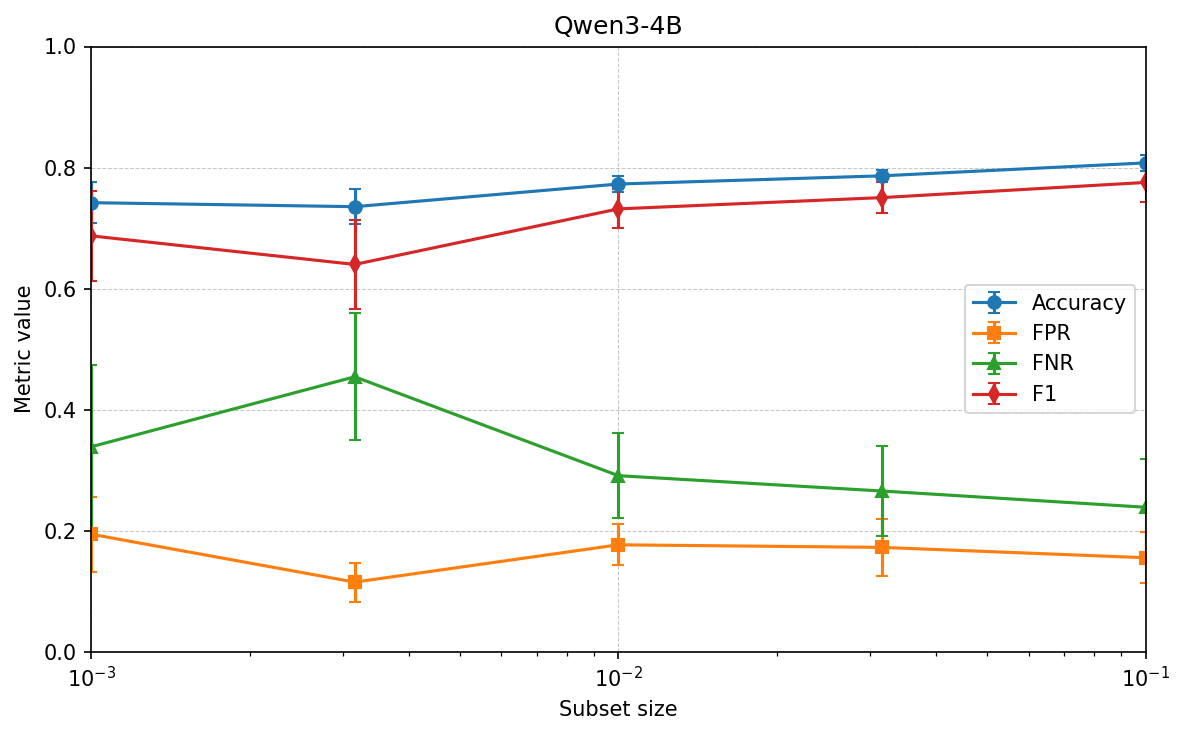

In [61]:
# qwen3-4b increasing subset size
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-22/polytope_hb-19-00-27"
]
metrics_mode = "standard"
out_dir = "robustness_plots"
outpath = out_dir + "/" + "qwen3-4b_increasing_subset_size.png"
run_summaries = find_run_summaries(base_dir[0])
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_metrics(metrics, outpath, metrics_mode, plot_title="Qwen3-4B")

/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/7/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/21/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/24/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/6/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/3/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/11/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/19/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15/14/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_mod

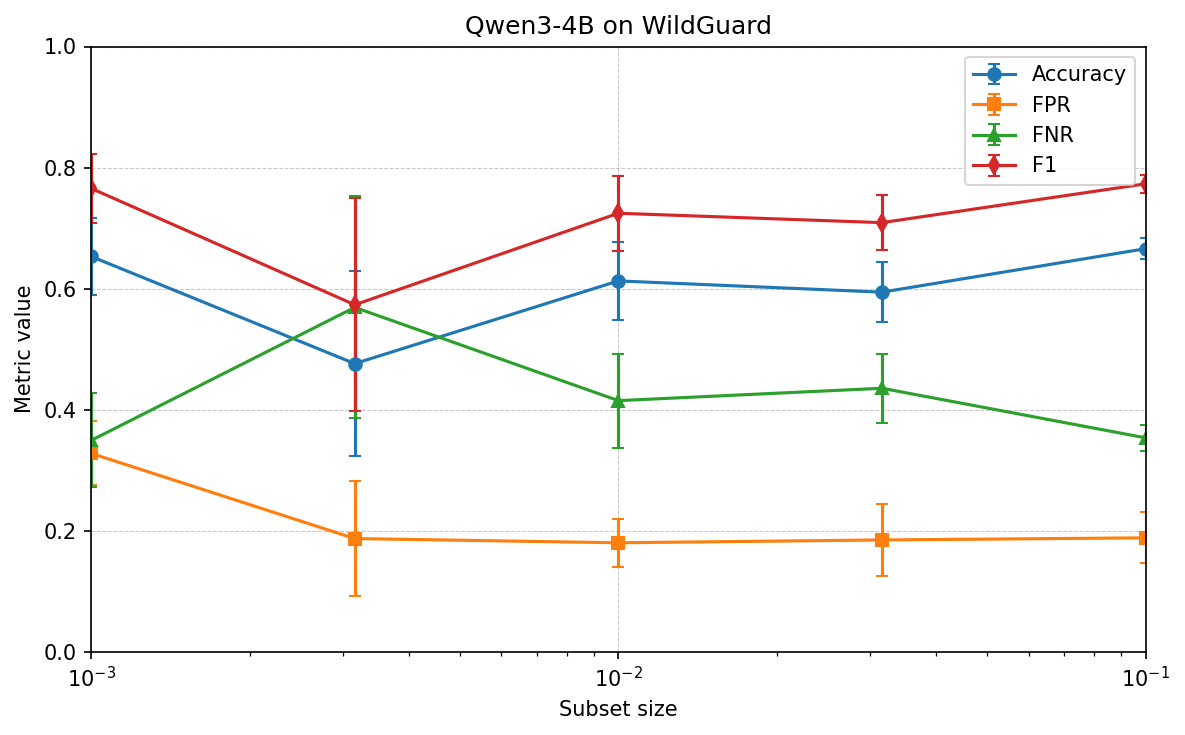

In [71]:
# qwen3-4b increasing subset size on wildguard
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-27-15"
]

metrics_mode = "test_model"
out_dir = "robustness_plots"
outpath = out_dir + "/" + "qwen3-4b_increasing_subset_size.png"
run_summaries = find_run_summaries(base_dir[0])
for r in run_summaries:
    print(r, end=",")
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_metrics(metrics, outpath, metrics_mode, plot_title="Qwen3-4B on WildGuard")

Saved average metrics vs subset size plot to robustness_plots/qwen2-1.5b_increasing_subset_size.png


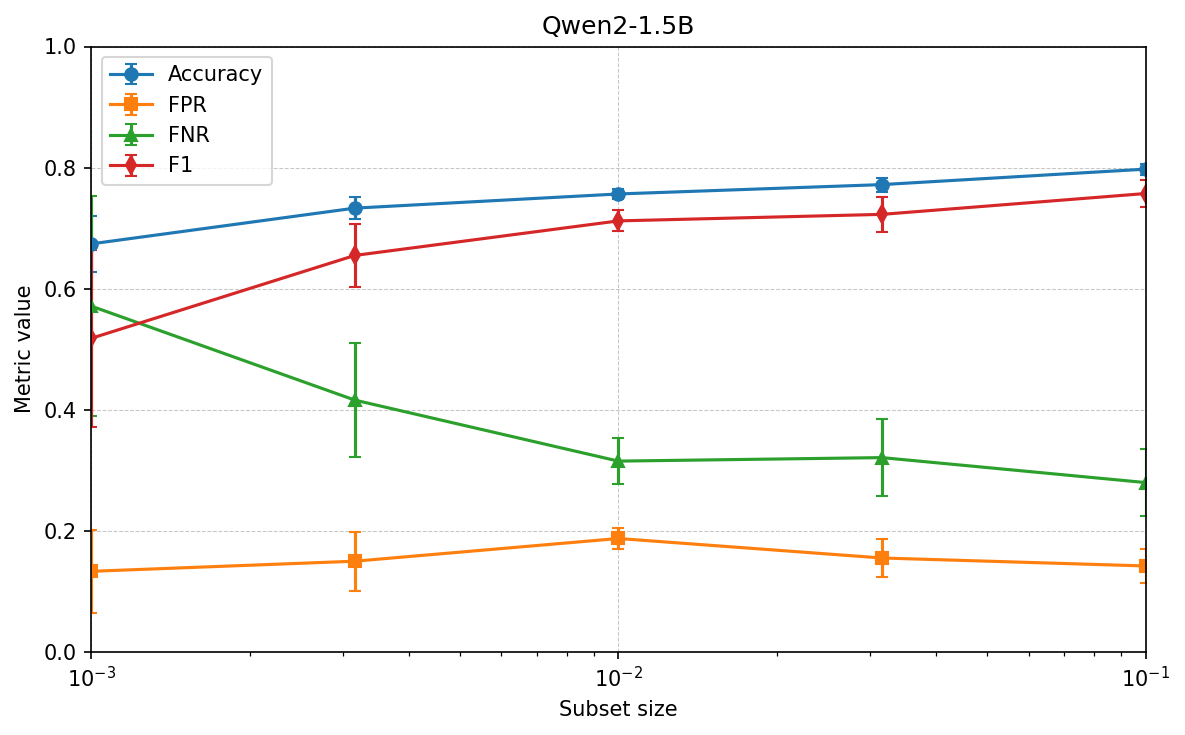

In [62]:
# qwen2-1.5b increasing subset size
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-23/polytope_hb-21-38-57"
]
metrics_mode = "standard"
out_dir = "robustness_plots"
outpath = out_dir + "/" + "qwen2-1.5b_increasing_subset_size.png"
run_summaries = find_run_summaries(base_dir[0])
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_metrics(metrics, outpath, metrics_mode, plot_title="Qwen2-1.5B")

/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/7/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/21/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/24/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/6/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/3/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/11/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/19/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40/14/run_summary.json,/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_mod

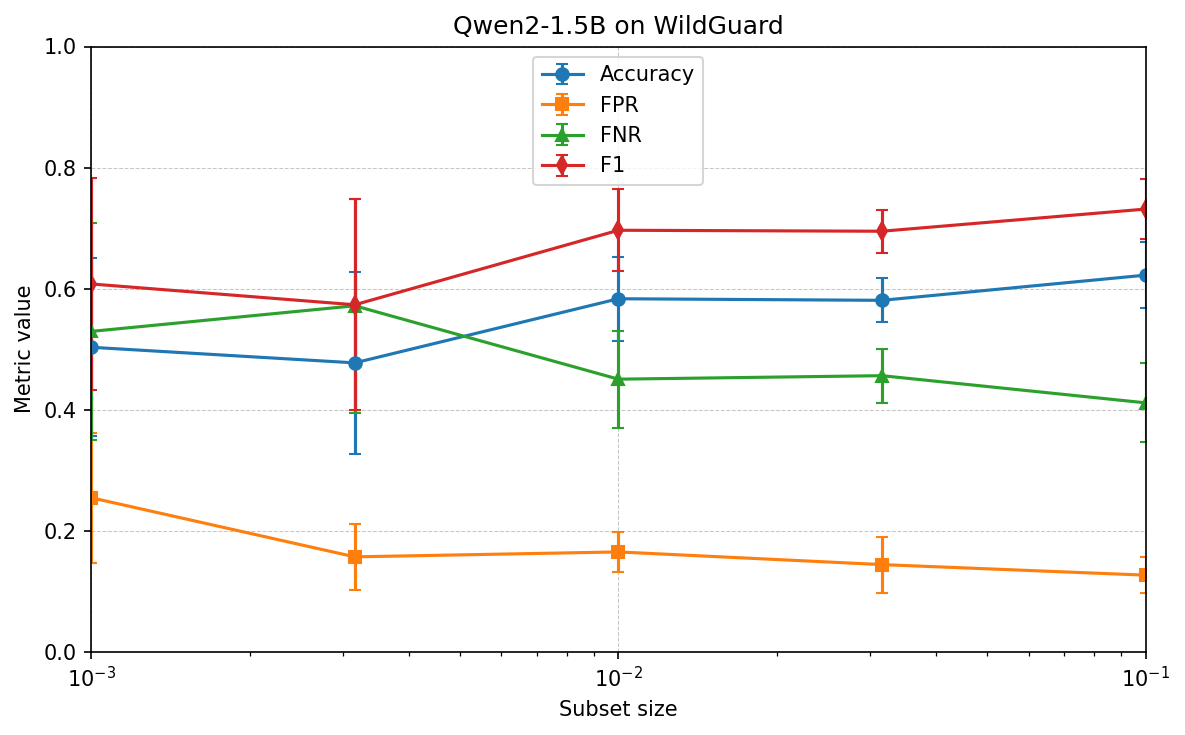

In [74]:
# qwen2-1.5b increasing subset size
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/wildguard/2025-10-24/test_model-12-38-40"
]
metrics_mode = "test_model"
out_dir = "robustness_plots"
outpath = out_dir + "/" + "qwen2-1.5b_increasing_subset_size.png"
run_summaries = find_run_summaries(base_dir[0])
for r in run_summaries:
    print(r, end=",")
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_metrics(metrics, outpath, metrics_mode, plot_title="Qwen2-1.5B on WildGuard")

n_positive: 500
Metrics: [{'subset_size': 1.0, 'acc': 0.5767457180500659, 'fpr': 0.003959548397453047, 'fnr': 0.9560753382742911, 'f1': 0.08374927075905879, 'category_distribution': {'animal_abuse': 206, 'child_abuse': 93, 'controversial_topics,politics': 548, 'discrimination,stereotype,injustice': 1386, 'drug_abuse,weapons,banned_substance': 906, 'financial_crime,property_crime,theft': 1547, 'hate_speech,offensive_language': 713, 'misinformation_regarding_ethics,laws_and_safety': 190, 'non_violent_unethical_behavior': 1407, 'privacy_violation': 636, 'safety,_ethics,_and_legality': 500, 'self_harm': 86, 'sexually_explicit,adult_content': 231, 'terrorism,organized_crime': 59, 'violence,aiding_and_abetting,incitement': 1492}, 'label_distribution': {'0': 9500, '1': 500}}, {'subset_size': 1.0, 'acc': 0.6011498383039885, 'fpr': 0.005832307774626786, 'fnr': 0.8982797307404637, 'f1': 0.18342324668955368, 'category_distribution': {'animal_abuse': 190, 'child_abuse': 91, 'controversial_topics,p

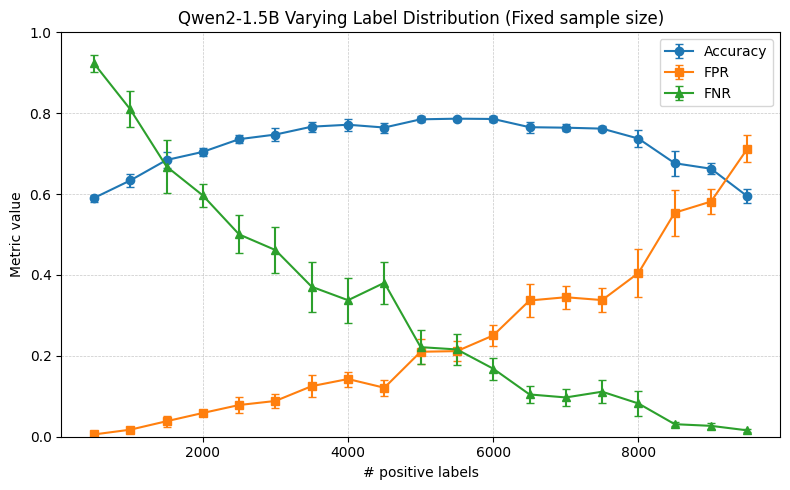

In [3]:
# qwen2-1.5b varying label distribution
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-24/polytope_hb-22-18-00"
]
out_dir = "robustness_plots"
outpath = out_dir + "/" + "qwen2-1.5b_varying_label_distribution.png"
metrics_mode = "standard"
run_summaries = find_run_summaries(base_dir[0])
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_metric_varying_label_distribution(
    metrics, outpath, title="Qwen2-1.5B Varying Label Distribution (Fixed sample size)"
)

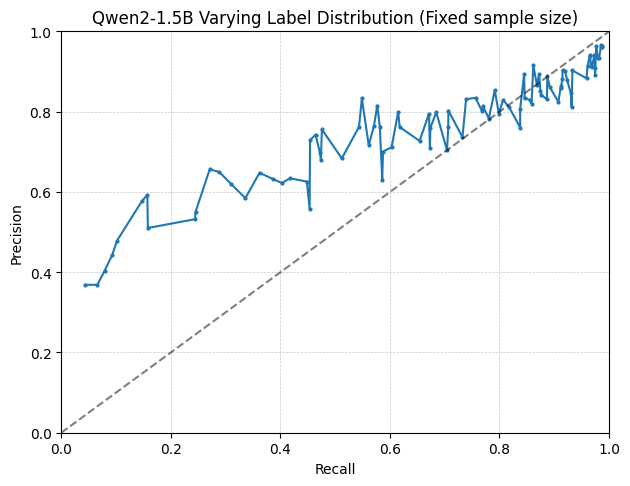

In [5]:
# qwen2-1.5b varying label distribution
base_dir = [
    "/scratch/gpfs/KOROLOVA/cl6486/SafetyPolytope/multirun/beaver_tails/2025-10-24/polytope_hb-22-18-00"
]
out_dir = "robustness_plots"
outpath = out_dir + "/" + "qwen2-1.5b_varying_label_distribution.png"
metrics_mode = "standard"
run_summaries = find_run_summaries(base_dir[0])
metrics = [extract_metrics(path, metrics_mode) for path in run_summaries]
plot_roc_curve_varying_label_distribution(metrics, outpath, title="Qwen2-1.5B Varying Label Distribution (Fixed sample size)")